In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from styling import *


In [2]:
# Read in FOA data
df1 = pd.read_excel('./datasets/FOA data/Wind_part1.xlsx', usecols=[1,2])
df2 = pd.read_excel('./datasets/FOA data/Wind_part2.xlsx', usecols=[1,2], header=0)

# Concatenate data
M7_FOA = pd.concat([df1, df2], ignore_index=True)

# Rename column
M7_FOA.columns.values[0] = 'datetime'

# Count missing values in "wind_m7" before dropping
missing_wind_m7 = M7_FOA['wind_m7'].isna().sum()
print(f"Missing values before dropping: {missing_wind_m7}")

# Drop rows where "wind_m7" is NaN
M7_FOA.dropna(subset=['wind_m7'], inplace=True)

# Convert datetime column to actual datetime format (to avoid sorting issues)
M7_FOA['datetime'] = pd.to_datetime(M7_FOA['datetime'], errors='coerce')

# Sort by datetime
M7_FOA.sort_values(by='datetime', inplace=True)

# Reset index after sorting
M7_FOA.reset_index(drop=True, inplace=True)



Missing values before dropping: 316200


In [3]:
# Read in Ammonit data

# Base directory where folders with CSV files are located
base_directory = './datasets/Ammonit data/'

# Empty list to store DataFrames
all_data = []

# Iterate through all files in the directory and subdirectories
for root, dirs, files in os.walk(base_directory):
    for file in files:
        # Check if the file is a CSV file
        if file.endswith('.csv'):
            # Construct the full file path
            file_path = os.path.join(root, file)

            # Read CSV file with only the first two columns
            amm_df = pd.read_csv(file_path, usecols=[0, 1])

            # Convert first column to datetime
            amm_df.iloc[:, 0] = pd.to_datetime(amm_df.iloc[:, 0], errors='coerce')

            # Append the processed DataFrame to the list
            all_data.append(amm_df)

# Concatenate all DataFrames in the list into one massive DataFrame
M7_Ammonit = pd.concat(all_data, ignore_index=True)
M7_Ammonit.columns.values[1] = 'Wind speed'
M7_Ammonit['datetime'] = pd.to_datetime(M7_Ammonit['datetime'], errors='coerce')

# Drop rows where any column has missing values
M7_Ammonit.dropna(inplace=True)

# Filter the DataFrame to remove rows where wind speed is < 0 or > 30
M7_Ammonit = M7_Ammonit[(M7_Ammonit['Wind speed'] >= 0) & (M7_Ammonit['Wind speed'] <= 30)]

# Sort by datetime column
M7_Ammonit.sort_values(by='datetime', inplace=True)

# Reset index after sorting
M7_Ammonit.reset_index(drop=True, inplace=True)

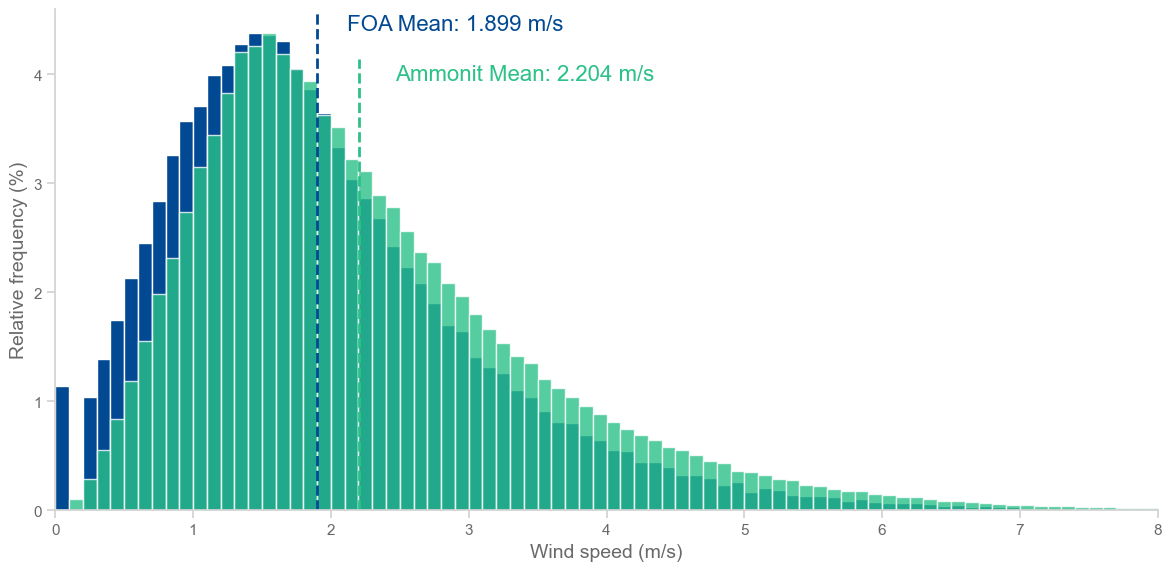

In [109]:
# Display distribution of wind speeds using histogram


# Count occurrences of each wind speed value for both datasets
value_counts_foa = M7_FOA['wind_m7'].value_counts().sort_index()

# Round Ammonit values to 1 decimal point 
# Need to use special rounding function to accomodate IEEE 754
from decimal import Decimal, ROUND_HALF_UP
value_counts_ammonit = M7_Ammonit['Wind speed'].apply(
    lambda x: float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP))).value_counts().sort_index() 


# Convert to relative frequencies (percentages)
value_counts_foa_rel = value_counts_foa / len(M7_FOA) * 100
value_counts_ammonit_rel = value_counts_ammonit / len(M7_Ammonit) * 100

# Make histogram
plt.figure(figsize=(12,6))
plt.bar(value_counts_foa_rel.index, value_counts_foa_rel.values, color=C_PICOM, edgecolor='white', 
        align='edge', width=0.1,label='FOA')
plt.bar(value_counts_ammonit_rel.index, value_counts_ammonit_rel.values, color=C_GREEN, edgecolor='white',
        align='edge', width=0.1, alpha=0.8, label='Ammonit')

# Add vertical lines for mean
mean_foa = M7_FOA['wind_m7'].mean()
mean_ammonit = M7_Ammonit['Wind speed'].mean()
plt.axvline(x=mean_foa, color=C_PICOM, linestyle='--', linewidth=2, ymax=0.999)
plt.axvline(x=mean_ammonit, color=C_GREEN, linestyle='--', linewidth=2, ymax=0.9)

# Add mean value labels
plt.text(mean_foa + 1.0, plt.ylim()[1]*0.95, f'FOA Mean: {round(mean_foa, 3)} m/s', 
         color=C_PICOM, ha='center', va='bottom')
plt.text(mean_ammonit +1.2, plt.ylim()[1]*0.85, f'Ammonit Mean: {round(mean_ammonit, 3)} m/s', 
         color=C_GREEN, ha='center', va='bottom')


plt.xlabel('Wind speed (m/s)', fontsize=14)
plt.ylabel('Relative frequency (%)', fontsize=14)
plt.xlim(0.0, 8.0)

#plt.legend()
plt.tight_layout()
plt.show()

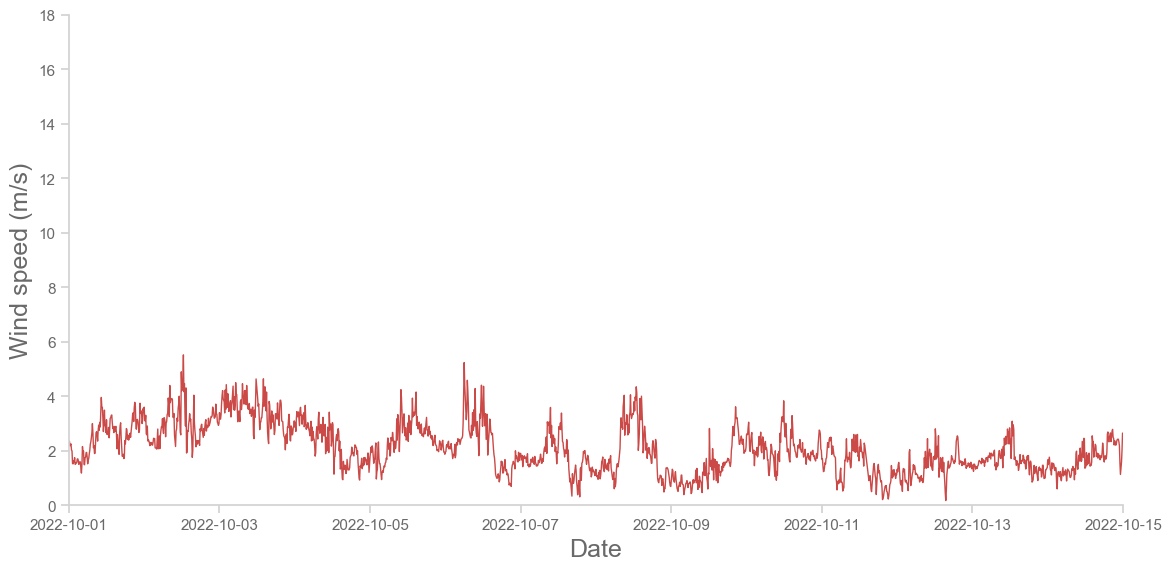

In [14]:
###
# Compare FOA and Ammonit to see if the values are the same
###

# Define the start and end dates
start_date = pd.to_datetime('2022-10-01')
end_date = pd.to_datetime('2022-10-15')

# Filter the dataframes for the date range
M7_FOA_filtered = M7_FOA[(M7_FOA['datetime'] >= start_date) & (M7_FOA['datetime'] <= end_date)]
M7_Ammonit_filtered = M7_Ammonit[(M7_Ammonit['datetime'] >= start_date) & (M7_Ammonit['datetime'] <= end_date)]

# Reset index
M7_FOA_filtered.reset_index(drop=True, inplace=True)
M7_Ammonit_filtered.reset_index(drop=True, inplace=True)

# Plot the data

plt.figure(figsize=(12, 6))

# Plot M7_FOA data
# plt.plot(M7_FOA_filtered['datetime'], M7_FOA_filtered['wind_m7'], label='M7_FOA', color=(0, 0.4470, 0.7410), linewidth=0.3)

# Plot M7_Ammonit data
plt.plot(M7_Ammonit_filtered['datetime'], M7_Ammonit_filtered['Wind speed'], label='M7_Ammonit', color=(C_RED), linewidth=1)

plt.xlabel('Date')
plt.ylabel('Wind speed (m/s)')
# plt.title('FOA vs. Ammonit wind speed at M7')
# plt.legend(('FOA', 'Ammonit'))
plt.ylim(0, 18)
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
# Show the plot
plt.tight_layout()
plt.show()


Optimal time shift: -127 minutes (MAE=0.236)


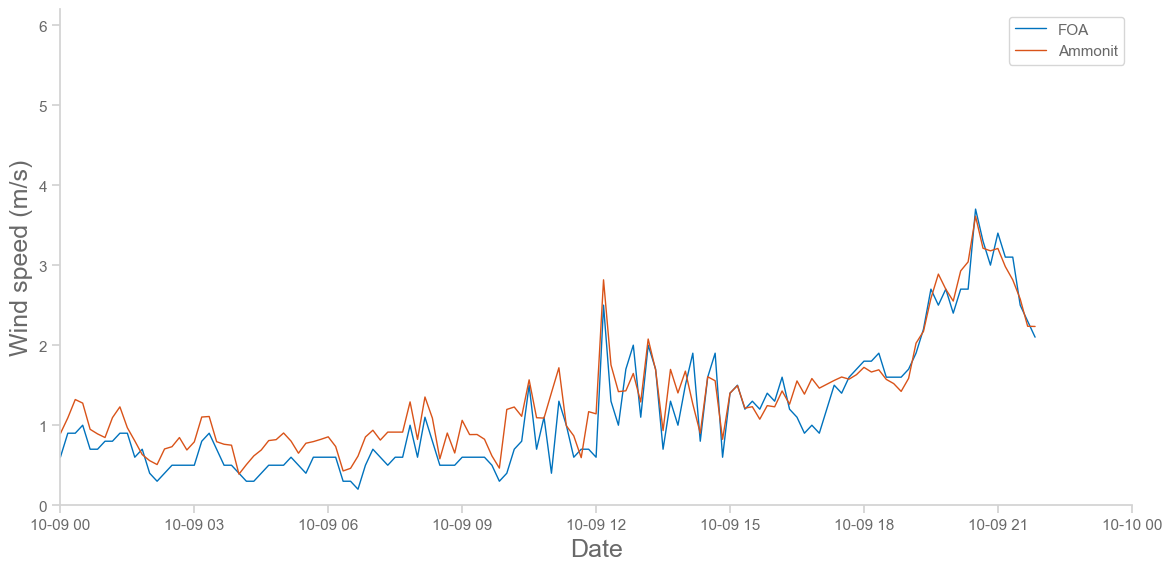

In [15]:
# Let's determine the offset in the timestamps by looping through different timestamp offsets and computing MAE
# When the lowest MAE is found, then the "true" offset in timestamp has been found


time_shifts = range(-3*60, 4*60, 1)  # this starts at -3 hours and goes up to +4 hours in increments of 1 minute
best_shift = None
lowest_MAE = float('inf')
tolerance = pd.Timedelta(minutes=0.5)

# Define the start and end dates
start_date = pd.to_datetime('2022-10-9')
end_date = pd.to_datetime('2022-10-10')

# Filter the dataframes for the date range
M7_FOA_subset = M7_FOA[(M7_FOA['datetime'] >= start_date) & (M7_FOA['datetime'] <= end_date)]
M7_Ammonit_subset = M7_Ammonit[(M7_Ammonit['datetime'] >= start_date) & (M7_Ammonit['datetime'] <= end_date)]


for shift in time_shifts:
    # Shift FOA timestamps
    M7_FOA_shifted = M7_FOA_subset.copy()
    M7_FOA_shifted['datetime'] += pd.Timedelta(minutes=shift)
    # M7_Ammonit_shifted = M7_Ammonit_subset.copy()
    # M7_Ammonit_shifted['datetime'] += pd.Timedelta(minutes=shift)

    # Match timestamps within tolerance
    merged = pd.merge_asof(
        M7_Ammonit, M7_FOA_shifted, on='datetime',
        tolerance=tolerance, direction='nearest'
    )

    # Drop unmatched rows
    matched = merged.dropna(subset=['wind_m7', 'Wind speed'])

    if not matched.empty:
        MAE = np.mean(np.abs(matched['Wind speed'] - matched['wind_m7']))

        if MAE < lowest_MAE:
            lowest_MAE = MAE
            best_shift = shift

print(f"Optimal time shift: {best_shift} minutes (MAE={lowest_MAE:.3f})")


# Create dataframe with best shift
M7_FOA_best_shifted = M7_FOA_subset.copy()
M7_FOA_best_shifted['datetime'] += pd.Timedelta(minutes=best_shift)
merged_best_shifted = pd.merge_asof(M7_Ammonit_subset, M7_FOA_best_shifted, on='datetime', tolerance=tolerance, direction='nearest')
merged_best_shifted = merged_best_shifted.dropna(subset=['wind_m7', 'Wind speed'])

# Plot data
plt.figure(figsize=(12, 6))
plt.plot(merged_best_shifted['datetime'], merged_best_shifted['wind_m7'], label='M7_FOA', color=(0, 0.4470, 0.7410), linewidth=1)
plt.plot(merged_best_shifted['datetime'], merged_best_shifted['Wind speed'], label='M7_Ammonit', color=(0.8500, 0.3250, 0.0980), linewidth=1)

plt.xlabel('Date')
plt.ylabel('Wind speed (m/s)')
plt.legend(('FOA', 'Ammonit'))
plt.ylim(0, 6.2)
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

plt.tight_layout()
#plt.grid(True)
plt.show()

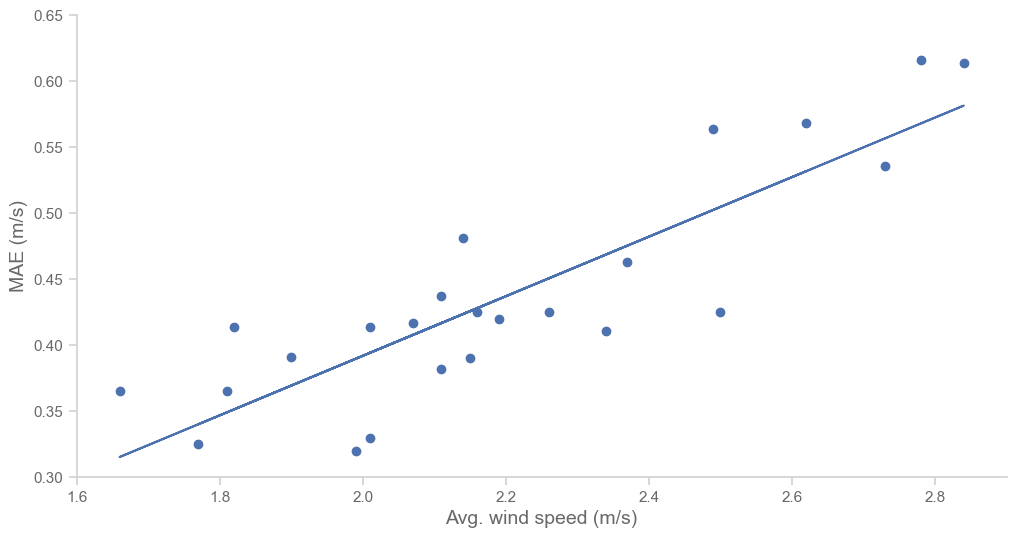

In [102]:
# Plot correlation between MAE and avg. wind speed

MAE_by_month = {
    'Month-Year': ['Apr 2022', 'May 2022', 'June 2022', 'July 2022', 'Aug 2022', 'Sept 2022', 'Oct 2022', 'Nov 2022', 'Dec 2022', 'Jan 2023', 'Feb 2023', 'Mar 2023', 'Apr 2023', 'May 2023', 'June 2023', 'July 2023', 'Aug 2023', 'Sept 2023', 'Oct 2023', 'Nov 2023', 'Dec 2023', 'Jan 2024', 'Feb 2024', 'Oct 2024'],
    'MAE': [0.463, 0.425, 0.417, 0.425, 0.365, 0.365, 0.320, 0.330, 0.390, 0.411, 0.568, 0.564, 0.414, 0.437, 0.414, 0.420, 0.391, 0.325, 0.382, 0.425, 0.616, 0.614, 0.536, 0.481],
    'Avg. wind speed': [2.37, 2.26, 2.07, 2.16, 1.66, 1.81, 1.99, 2.01, 2.15, 2.34, 2.62, 2.49, 2.01, 2.11, 1.82, 2.19, 1.90, 1.77, 2.11, 2.50, 2.78, 2.84, 2.73, 2.14]
}

coeffs = np.polyfit(MAE_by_month['Avg. wind speed'], MAE_by_month['MAE'], 1)
trendline = np.poly1d(coeffs)
avg_MAE_pred = trendline(MAE_by_month['Avg. wind speed'])
ss_res = np.sum((MAE_by_month['MAE'] - avg_MAE_pred) ** 2)
ss_tot = np.sum((MAE_by_month['MAE'] - np.mean(MAE_by_month['MAE'])) ** 2)
r_squared = 1 - (ss_res/ss_tot)


plt.figure(figsize=(12, 6))
plt.scatter(MAE_by_month['Avg. wind speed'], MAE_by_month['MAE'])
plt.plot(MAE_by_month['Avg. wind speed'], avg_MAE_pred)
plt.ylabel('MAE (m/s)', fontsize=14)
plt.xlabel('Avg. wind speed (m/s)', fontsize=14)
plt.ylim(0.3, 0.65)
plt.xlim(1.6, 2.9)
plt.show()


In [ ]:
# Figuring out what days/months have no data for FOA data

# Full range of datetime data
full_range = pd.date_range(start=M7_FOA['datetime'].min(), end=M7_FOA['datetime'].max(), freq='D')

# Convert recorded timestamps to just dates (removing time part)
recorded_dates = M7_FOA['datetime'].dt.date.unique()

# Identify missing days
missing_days = sorted(set(full_range.date) - set(recorded_dates))

# Convert to DataFrame
missing_df = pd.DataFrame(missing_days, columns=['missing_dates'])
missing_df['month'] = missing_df['missing_dates'].apply(lambda x: x.replace(day=1))  # Group by month
missing_df['gap'] = missing_df['missing_dates'].diff().dt.days

# Count missing days per month
missing_per_month = missing_df.groupby('month').size()

# Generate a full month range (start of each month)
full_month_range = pd.date_range(start=missing_df['month'].min(), end=missing_df['month'].max(), freq='MS')

# Reindex to include all months in the dataset, filling with 0 where there are no missing data
missing_per_month = missing_per_month.reindex(full_month_range, fill_value=0)